# 5.1 중고나라 휴대폰 거래가격 예측하기

## Step 1 탐색적 분석: 중고나라 데이터 분석하기

중고나라 데이터셋은 다음과 같은 피처로 구성되어 있다.

* create_date: 판매 게시글이 올라온 시점
* price: 휴대폰의 거래 가격
* text: 제목과 본문을 합친 텍스트 데이터
* phone_model: 휴대폰 기종
* factory_price: 공시 가격
* maker: 휴대폰 제조사
* price_index: 판매 게시글이 올라온 시점에서의 휴대폰 물가 지수 데이터

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/used_mobile_phone.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


위의 결과를 보면 약 5000개의 데이터가 결측값 없이 구성되어 있다는 것을 알 수 있다.

다음으로 개별 피처들을 탐색해보자.

In [2]:
df['month'] = df['create_date'].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력
df['month'].value_counts()

month
2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: count, dtype: int64

위의 결과를 보면, 이 데이터는 2016년 10월, 2017년 3월에 집중적으로 수집된 데이터라는 것을 알 수 있다.

데이터의 개수를 일자별 시계열 그래프로 나타내보자.

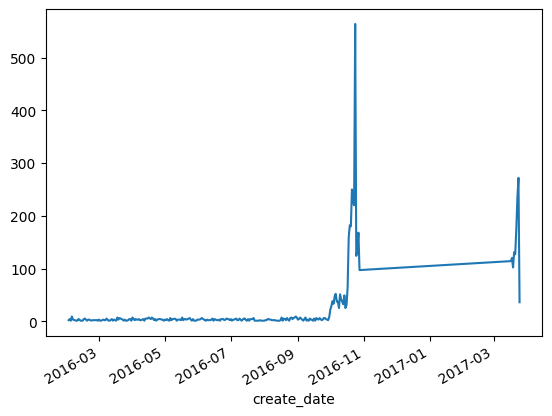

In [3]:
# 일별 거래 횟수를 계산하여 그래프로 출력
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts().sort_index()
df_day.plot()
plt.show()

아래와 같이 price 피처의 탐색을 통해 중고나라에서 거래되고 있는 중고 휴대폰 가격이 어느 정도인지 살펴볼 수 있다. 대부분의 중고 휴대폰이 60만원 이하의 가격대를 형성하고 있으며, 몇몇은 그 이상에도 거래되는 것을 알 수 있다.

<Axes: >

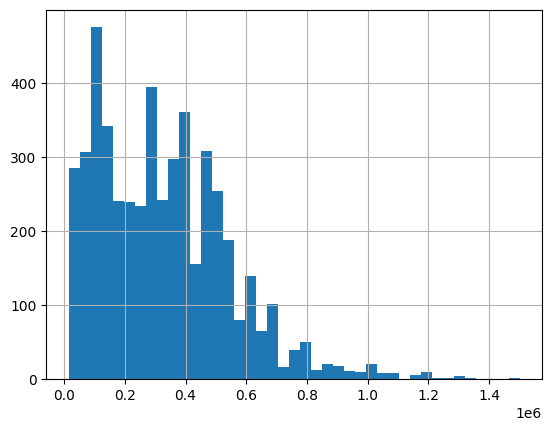

In [4]:
df['price'].hist(bins='auto')

이번에는 휴대폰의 동일 기종 내에서의 가격 분포를 살펴보자.

그래프로 출력한 결과, 동일 기종 내에서 price 피처의 분포는 정규분포에 가깝다는 것을 알 수 있다.

<Axes: >

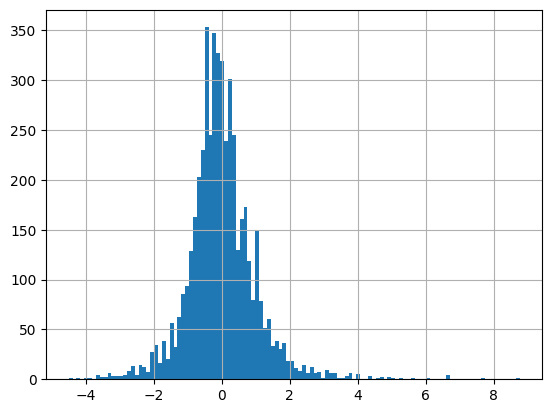

In [5]:
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 모든 데이터의 z-score를 계산
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins='auto')

이번에는 factory_price 피처의 분포, factory_price와 price 간의 관계를 탐색해보자.

출력 결과, 두 피처는 양의 상관 관계를 가지고 있다. 이를 통해 factory_price는 중고 휴대폰 판매 가격에 꽤 중요한 영향을 미칠 것이라 추정할 수 있다.

<Axes: xlabel='factory_price', ylabel='price'>

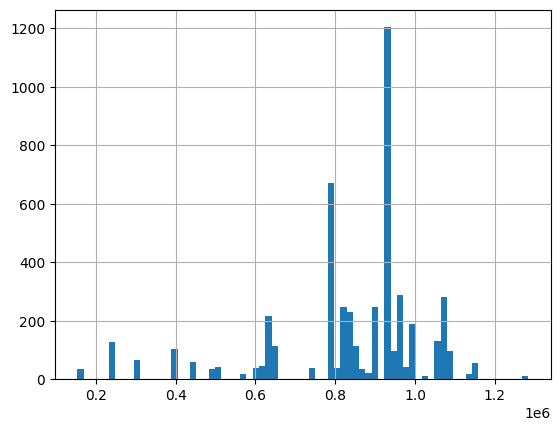

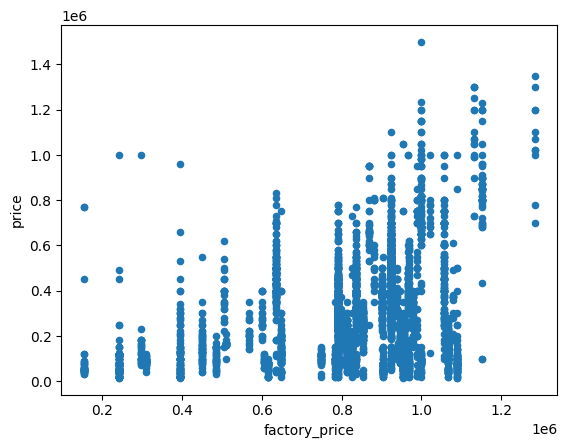

In [6]:
# factory_price 피처의 분포를 탐색
df['factory_price'].hist(bins='auto')

# factory_price와 price 피처를 산점도 그래프로 출력
df.plot.scatter(x='factory_price', y='price')

다음으로 phone_model 피처를 탐색해보자. 휴대폰 기종의 개수는 총 64개로, 상위 5개의 기종을 제외하면 대부분 10~90개 사이의 데이터를 가지고 있다는 것을 알 수 있다.

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: count, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x24fe4839060>,
 'caps': [<matplotlib.lines.Line2D at 0x24fe48395a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24fe4838dc0>],
 'medians': [<matplotlib.lines.Line2D at 0x24fe47da740>],
 'fliers': [<matplotlib.lines.Line2D at 0x24fe4791900>],
 'means': []}

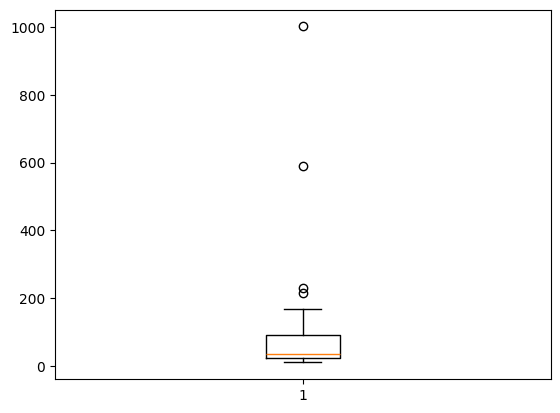

In [7]:
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

plt.boxplot(model_counts)

지금까지 탐색한 피처를 바탕으로 가격 예측 모델을 학습해보자.

랜덤 포레스트란?

의사결정 나무 분석 방법을 응용한 것으로 의사결정 나무를 여러 개 모아 하나의 숲을 구성하는 방법이다. 하나의 모델이 정답을 푸는 것이 아닌, 여러 개의 모델이 정답을 함께 푸는 것이기 때문에 더 정확한 학습이 가능하다. 회귀와 분류, 두 가지에 모두 적용이 가능하다.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 학습/테스트용 데이터로 분리
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

아래 실행 결과는 모델의 예측 평가 점수인 R2 Score, RMSE를 나타낸 것이다. Train score와 Test score 차이가 심한 것을 미루어 볼 때, 이 예측 모델은 과적합이 일어났다고 할 수 있다.

In [9]:
# 학습한 모델을 평가
print('MSE train: %.3f, test: %.3f' %(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 10640619025.222, test: 13893157891.864
R^2 train: 0.781, test: 0.682


아래 코드는 랜덤 포레스트 모델의 피처 중요도를 출력한 것이다.

[('factory_price', 0.4063583339595921),
 ('maker_apple', 0.29795812712409653),
 ('phone_model_galaxy s3 3g 8gb', 0.02257731984968985),
 ('phone_model_iphone se 64gb', 0.021848188036336067),
 ('price_index', 0.0206641671490979),
 ('phone_model_galaxy s4 32gb', 0.01599432648574869),
 ('month_2017-03', 0.014719322119881547),
 ('maker_samsung', 0.013810727580794236),
 ('phone_model_galaxy s6 32gb', 0.012396005482170937),
 ('month_2016-05', 0.010778004164559749)]

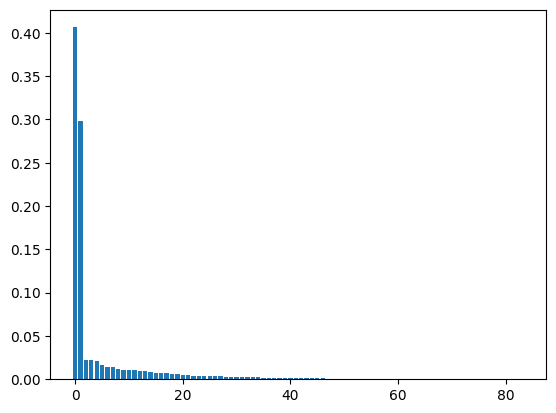

In [10]:
# 학습한 모델의 피처 중요도를 그래프로 살펴본다
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

그렇다면 시간은 모델에 어떤 영향을 미칠까? month 피처의 중요도를 살펴보자.

아래 코드 실행 결과, 최근에 가까운 month일수록 피처의 중요도가 높아지는 것을 알 수 있다.

In [11]:
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if 'month' in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.014719322119881547)
('month_2016-05', 0.010778004164559749)
('month_2016-09', 0.008511622747300024)
('month_2016-04', 0.007567276431182027)
('month_2016-10', 0.006226415237813844)
('month_2016-06', 0.00453375330145075)
('month_2016-08', 0.003733504412851896)
('month_2016-07', 0.0027321104680019417)
('month_2016-03', 0.0023735262959717527)
('month_2016-02', 0.0009516164579494479)


## Step 2 피처 엔지니어링: 예측 모델 개선하기

지금까지 수행한 탐색적 데이터 분석의 내용은 다음과 같다.

* date: 월 단위로 살펴본 결과, 2016년 10월과 2017년 3월의 데이터가 가장 많다. 최근에 가까운 월(Month)일수록 예측 모델에 중요한 피처
* price: 기종별 가격의 분포는 정규분포의 형태를 띠고 있다.
* factory_price: price 피처와의 양의 상관 관계가 관찰된다. 또한 예측 모델의 피처 중요도 분석 결과, 가장 중요한 피처로 나타났다.
* phone_model: 소수의 인기 기종이 많은 데이터를 가지고 있다.
* maker: Apple 브랜드가 가장 많으며, 가격 예측에서도 Apple 브랜드 여부는 가장 중요한 피처 중 하나이다.
* price_index: 월별 변동이 크지 않으며, 총 4개의 값만을 가지고 있다. 그다지 중요한 피처는 X

가장 먼저 create_date 피처를 분석에 활용하기 위해 시간 점수라는 것을 만들어보자.

1. create_date를 unixtime으로 변환. unixtime은 시간을 정수로 표현한 것이며, 값이 클수록 최근에 가까움
2. min-max 스케일링을 적용하여 unixtime을 상대적인 점수로 계산
3. 점수가 1에 가까울수록 최근에 작성한 게시물을 의미, 0에 가까울수록 오래된 것을 의미

In [12]:
# 데이터를 다시 불러온다.
df = pd.read_csv('data/used_mobile_phone.csv')

from datetime import datetime
import time

# create_date 피처를 수치적으로 계산하기 위해 unixtime으로 변환하는 함수를 정의
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, "%Y-%m-%d").timetuple())
    return timestamp

# create_date 피처를 현재와 얼마나 가까운 데이터인지 판단하기 위한 점수를 생성
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10])) # :10은 년-월-일까지 입력되는 것을 의미

# 변환된 unixtime에 min-max 스케일링을 적용
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


다음으로 phone_model에 대한 피처 엔지니어링을 수행하자. phone_model 피처는 제품명+용량을 구성되어 있기에 이를 나누어주면 2개의 분리된 피처를 얻을 수 있다.

In [13]:
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


아래 코드는 phone_model 피처를 분리함으로써 얻을 수 있는 효과를 알아보기 위해 피처 분리 이전과 이후의 분포를 상자 그림으로 비교해보자.

{'whiskers': [<matplotlib.lines.Line2D at 0x24fe852f1f0>,
 'caps': [<matplotlib.lines.Line2D at 0x24fe53f4b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x24fe852ef50>,
 'medians': [<matplotlib.lines.Line2D at 0x24fe53f6830>,
 'fliers': [<matplotlib.lines.Line2D at 0x24fe53f7580>,
 'means': []}

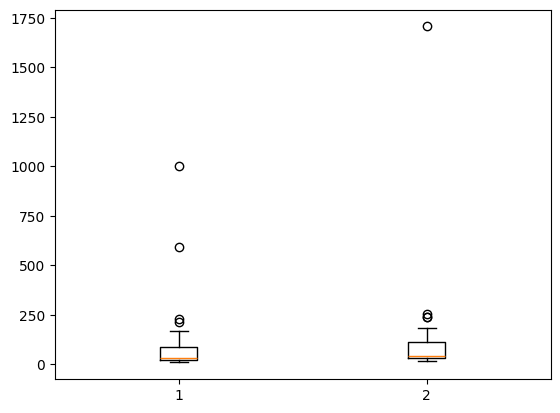

In [14]:
model_counts = df['phone_model'].value_counts()

model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

위를 살펴보면, 쏠림 현상이 심해진 하나의 기종을 제외하곤 전체적인 분포가 안정적으로 변한 것을 알 수 있다.

이번에는 텍스트 정보에 대한 피처 엔지니어링을 수행해보자. 텍스트 정보에는 물품의 상태가 나타나 있고, 가격 예측에 영향을 미칠 것이다. 즉, 감성 분류가 필요하다. 감성 분류를 어떻게 판단할 수 있을까? 기종별 가격의 분포는 정규분포다 라는 정보를 활용해보자.

1. price 피처를 같은 기종 내 z-score로 변환한다
2. z-score 기준, 상위 5%에 속하는 가격의 게시글은 상태가 좋음, 하위 5%는 상태가 나쁨, 그리고 그 외는 보통으로 판단한다.
3. 정의한 세 가지 상태를 감성 분류의 정답 데이터로 사용한다.

-1.3966616903783375
1.666982156397844


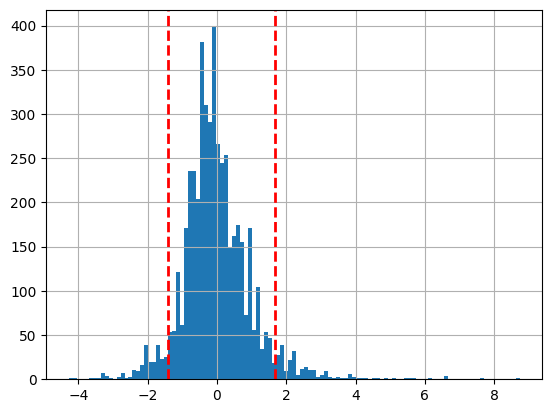

In [15]:
# 거래 가격의 z-score를 계산
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score의 분포를 그래프로 출력
ax = df['price_by_group'].hist(bins='auto')

# z-score 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound로 지정
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound , upper_bound 그래프에 추가
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound, upper_bound 출력
print(lower_bound)
print(upper_bound)

감성 분류의 정답 데이터를 price_level 피처로 생성한 결과는 다음과 같다.

In [16]:
# lower_bound 보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류
def get_price_level(price, lower, upper):
    if price <= lower:
        return '0'
    elif price >= upper:
        return '2'
    else:
        return '1'

df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


다음으로 텍스트 전처리 과정을 진행해보자.

In [17]:
import pickle
import re

# 중고나라 불용어 사전을 불러온다.
with open('data/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

# 불용어 사전에 등록된 단어 10개를 출력
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


In [18]:
from konlpy.tag import Okt

# '+'를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

# 위 함수들을 적용한 형태소 추출을 테스트
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


다음은 추출한 형태소에서 가장 빈도수가 높은 형태소 2500개를 선정한다. 2500개로 단어를 제한하는 이유는 텍스트 데이터의 피처를 제한하기 위해서이다.

In [19]:
from collections import Counter

# get_pos() 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출
counter = Counter(corpus)
common_words = [key for key, _ in counter.most_common(2500)]
common_words

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

전처리가 완료된 텍스트 데이터를 학습 데이터셋 형태로 변환한다. 피처를 변환하는 방식은 TF-IDF 방식을 사용하였고, 클래스 불균형을 맞춰주기 위해 부정:중립:긍정 데이터를 1:3:1비율로 데이터를 추출하였다.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 빈출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의
def get_common_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] in common_words]

# 1:3:1 비율로 랜덤샘플링을 수행
negative_random = df[df['price_level'] == '0'].sample(321, random_state=30)
neutral_random = df[df['price_level'] == '1'].sample(321*3, random_state=30)
positive_random = df[df['price_level'] == '2'].sample(321, random_state=30)

# 샘플링 완료된 데이터셋을 정의
df_sample = pd.concat([negative_random, neutral_random, positive_random])

# TF-IDF를 수행하여 피처를 변환
index_vectorizer = CountVectorizer(tokenizer= lambda x: get_common_pos(x))
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋을 정의
y = df_sample['price_level']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
print(x_train.shape)
print(x_test.shape)

C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(1284, 2476)
(321, 2476)


위의 코드를 실행하면, 학습 데이터셋은 1284개, 테스트 데이터셋은 321개가 생성되었고, 형태소를 표현하는 피처는 2476개가 생성되었다.

아래의 코드는 분류 모델을 학습 및 예측한 결과이다. 약 0.8의 정확도로 꽤나 정확하게 분류 모델이 학습되었음을 알 수 있다.

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# 비선형 SVM 분류 모델을 학습하고 평가
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.1)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

# Confusion Matrix를 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

Accuracy: 0.77
[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


## Step 3 예측: 중고 휴대폰 거래가 예측하기

피처 엔지니어링 과정을 통해 정리된 피처는 다음과 같다.

* create_time_score: create_date 피처를 unixtime으로 바꾸어 얼마나 오래된 게시물인지를 0~1 사이의 값으로 계산하여 표현
* phone_model_storage, phone_model_detail: phone_model 피처를 둘로 나눈 것
* product_status: 동일 기종 내 상대 가격을 기준으로 텍스트 데이터의 감성을 분류한 것.총 3개의 범주로 표현

아래의 실행 결과는 새로운 피처로 예측 모델을 다시 학습한 것이다.

In [22]:
# text 피처로부터 상품 상태 피처를 생성
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

# 랜덤 포레스트 모델 학습을 위한 데이터를 준비
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage', 'phone_model_detail', 'product_status']]
copy_df = df.copy()
df = pd.get_dummies(df, columns=['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

In [23]:
df

,price,factory_price,price_index,create_time_score,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,550000.0,924000,95.96,0.985612,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,380000.0,979000,103.05,0.640288,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,300000.0,854000,103.05,0.637890,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,290000.0,836000,95.96,0.995204,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,280000.0,396000,102.59,0.165468,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,1300000.0,1283700,103.05,0.601918,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4947,1300000.0,1130800,103.05,0.635492,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4948,1300000.0,1130800,103.05,0.551559,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4949,1350000.0,1283700,103.05,0.589928,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Train R2 score, Test R2 score 등의 지표가 매우 상승하였지만, 여전히 과적합이 발생함을 알 수 있다. 그리고 피처 중요도를 다시 확인한 결과, 영향력이 높은 피처 중 create_time_score, product_status가 있다는 것을 확인할 수 있다.

MSE train: 4772451883.256, test: 10953846052.218
R^2 train: 0.902, test: 0.750


[('factory_price', 0.2546015635882139),
 ('maker_apple', 0.2537195672949622),
 ('create_time_score', 0.11680576003406899),
 ('phone_model_storage_16gb', 0.06068316041121575),
 ('product_status_2', 0.04728575561575539),
 ('phone_model_detail_galaxy s7 edge', 0.028859166914413044),
 ('phone_model_storage_64gb', 0.02520978620154072),
 ('phone_model_detail_galaxy note5', 0.024700951686884413),
 ('phone_model_detail_galaxy s7', 0.02278028502216092),
 ('product_status_0', 0.021714478334947846)]

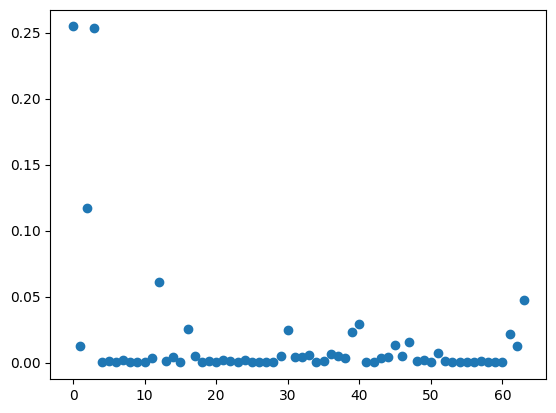

In [24]:
# 학습/테스트 데이터를 분리
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습하고 평가
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' %(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

# 피처 중요도 plot을 출력
importances = forest.feature_importances_
plt.plot(importances, 'o')

# 피처 중요도를 출력
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

산점도 그래프로도 확인을 해보면, 몇몇 이상치를 제외하고 예측이 잘 된 것을 확인할 수 있다.

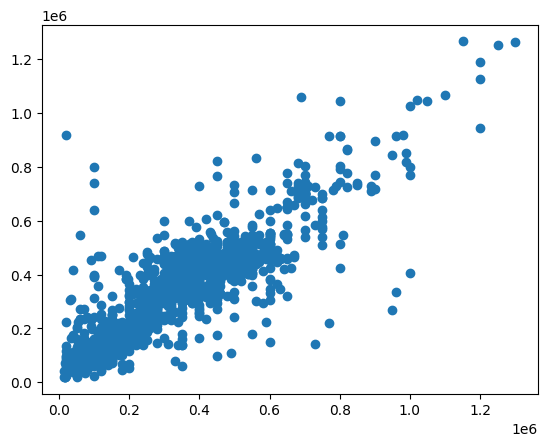

In [25]:
plt.scatter(y_test.values, y_test_pred)

모델을 학습할 때 파라미터를 어떻게 설정하였느냐에 따라 예측의 성능이 달라질 수 있다. 반복적인 실행으로 최적의 파라미터를 찾아 내는 방법 중 하나가 Greedy Randomized Search 방법이다.

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Randomized Search로 찾아낼 파라미터 후보군을 각각 리스트로 선정
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 저의
random_grid = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'bootstrap':bootstrap}
forest = RandomForestRegressor()
optimal_forest = RandomizedSearchCV(estimator= forest,
                                    param_distributions= random_grid,
                                    n_iter= 100,
                                    cv = 3,
                                    verbose= 2,
                                    random_state= 42,
                                    n_jobs= -1)

# RandomizedSearchCv 모델을 학습
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

아래 출력 결과는 Greedy Randomized Search를 실행하여 찾아낸 최적의 파라미터이다.

In [27]:
print(optimal_forest.best_params_)

{'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}


최적의 파라미터로 다시 한 번 학습한 모델의 출력 결과는 아래와 같다. Train score는 다소 감소하였지만, Test score와의 차이가 좁혀진 것을 볼 수 있고, 모델이 가지고 있던 과적합 문제가 해결되었다고 할 수 있다.

MSE train: 9269655794.730, test: 8671029045.186
R^2 train: 0.809, test: 0.802


[('factory_price', 0.12674242904244679),
 ('maker_apple', 0.1068588572402814),
 ('phone_model_storage_128gb', 0.09412943082595329),
 ('phone_model_storage_64gb', 0.0877524269858356),
 ('phone_model_detail_iphone 7', 0.0847981194870632),
 ('create_time_score', 0.049954596889029645),
 ('product_status_0', 0.039557818695605214),
 ('phone_model_detail_iphone 7 plus', 0.039183595634931435),
 ('phone_model_detail_iphone 6', 0.03584061388621351),
 ('product_status_2', 0.03485608048186749)]

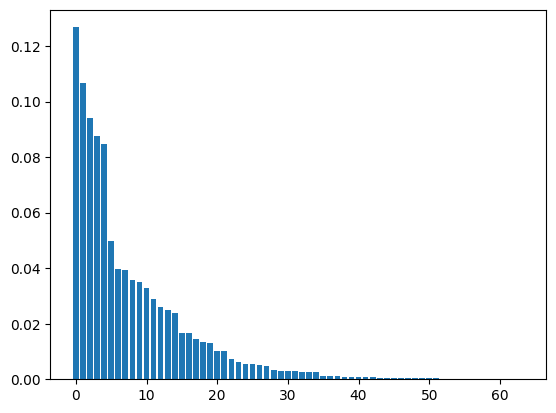

In [28]:
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' %(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' %(r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

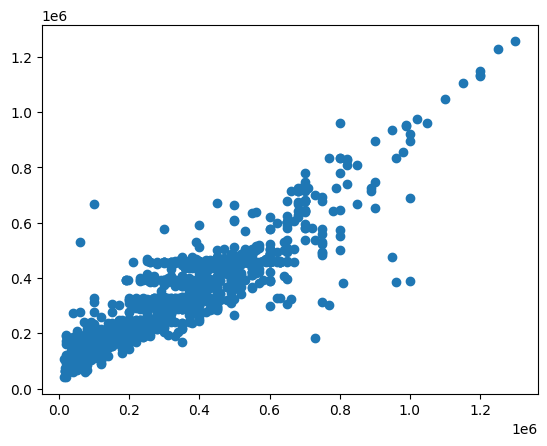

In [29]:
plt.scatter(y_test.values, y_test_pred)

성능이 많이 향상된 것을 확인할 수 있다.

## Step 4 프로토타입: 얼마고(Almhago?)

지금까지 완성한 중고 휴대폰 가격 예측 모델을 프로그램 형태로 만들어보자.

In [30]:
df

,price,factory_price,price_index,create_time_score,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,550000.0,924000,95.96,0.985612,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,380000.0,979000,103.05,0.640288,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,300000.0,854000,103.05,0.637890,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,290000.0,836000,95.96,0.995204,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,280000.0,396000,102.59,0.165468,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,1300000.0,1283700,103.05,0.601918,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4947,1300000.0,1130800,103.05,0.635492,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4948,1300000.0,1130800,103.05,0.551559,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4949,1350000.0,1283700,103.05,0.589928,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [31]:
df

,price,factory_price,price_index,create_time_score,maker_apple,maker_huawei,maker_lg,maker_pantech,maker_samsung,maker_sky,...,phone_model_detail_nexus 5x,phone_model_detail_optimus g,phone_model_detail_vega iron2,phone_model_detail_vega secret up,phone_model_detail_wine smart jazz,phone_model_detail_xperia z3,phone_model_detail_y6,product_status_0,product_status_1,product_status_2
0,550000.0,924000,95.96,0.985612,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,380000.0,979000,103.05,0.640288,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,300000.0,854000,103.05,0.637890,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,290000.0,836000,95.96,0.995204,False,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,280000.0,396000,102.59,0.165468,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946,1300000.0,1283700,103.05,0.601918,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4947,1300000.0,1130800,103.05,0.635492,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4948,1300000.0,1130800,103.05,0.551559,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4949,1350000.0,1283700,103.05,0.589928,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [32]:
import joblib

# 모델명 + 용량을 출고가를 찾을 수 있는 딕셔너리를 생성
model_to_factory_price_dict = {}
for index, row in copy_df.iterrows(): # copy_df는 분리 전 df
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']

print(str(model_to_factory_price_dict)[:40])

# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성
col_to_index_dict = {}
for idx, col in enumerate(df.columns[1:]): # df는 명목형 변수 분리 후 df
    col_to_index_dict[col] = idx

print(str(col_to_index_dict)[:40])

# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장
with open('data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)

with open('data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)

with open('data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_words, f, pickle.HIGHEST_PROTOCOL)

with open('data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)

with open('data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)

with open('data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, 'data/used_mobile_pickles/rf_regressor.pickle', compress=1)

{('iphone 6', '64gb'): 924000, ('galaxy 
{'factory_price': 0, 'price_index': 1, '


['data/used_mobile_pickles/rf_regressor.pickle']

예측에 필요한 파일 로드

In [33]:
import pickle

with open('data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load('data/used_mobile_pickles/rf_regressor.pickle')

In [34]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == "0":
            status = "불량한"
        elif prd_status == "1":
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'], 
                            predicted_price, 
                            self._get_prd_status(input_dict['text']))

실행해보자.

In [35]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 두 개(price_index, create_time_score)의 피처를 정의합니다.
recent_price_index = 95.96
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글을 입력합니다.
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트를 생성합니다.
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)

# 입력한 데이터로 판매 가격을 예측합니다.
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 불량한 상태입니다. Almhago 예상 가격은 187256 원 입니다.


C:\Users\CHOYS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
